# LGBM Model 

In [1]:
import pandas as pd 
import numpy as np 

## Setting Up the Data 

In [2]:
df = pd.read_csv('modeling_data_sample.csv')
print(df.shape)
df.head()

(150, 18)


,TEAM_SEASON,LS_MIN,LS_EFG_PCT,LS_FTA_RATE,LS_TM_TOV_PCT,LS_OREB_PCT,LS_OPP_EFG_PCT,LS_OPP_FTA_RATE,LS_OPP_TOV_PCT,LS_OPP_OREB_PCT,HEIGHT_INCHES,WEIGHT,EXP,LS_WIN_PCT,PO_WINS,TEAM_ID,TEAM_NAME,PO_WINS_CAT
0,1610612737_2019-20,19.856225,0.517043,0.252180,0.149825,0.226813,0.526620,0.313881,0.133524,0.235405,78.812500,217.250000,3.687500,0.354,0.0,1610612737,Hawks,R1/Lottery
1,1610612737_2020-21,24.459721,0.519798,0.257725,0.148807,0.214129,0.536863,0.277694,0.142510,0.234664,78.235294,216.058824,3.823529,0.299,10.0,1610612737,Hawks,Conf. Finals
2,1610612737_2021-22,19.359828,0.527291,0.280572,0.134667,0.223747,0.535920,0.260534,0.126992,0.220961,78.352941,212.882353,4.411765,0.569,1.0,1610612737,Hawks,R1/Lottery
3,1610612737_2022-23,19.634129,0.515657,0.252946,0.140765,0.214893,0.532730,0.251615,0.131051,0.222704,78.352941,212.705882,2.823529,0.524,2.0,1610612737,Hawks,R1/Lottery
4,1610612737_2023-24,17.248412,0.555474,0.240233,0.135582,0.279755,0.537575,0.270382,0.132214,0.209344,78.352941,212.705882,3.823529,0.500,NaN,1610612737,Hawks,NaN


In [3]:
def modeling_data_setup(data,test_seasons,this_season,model_type):
    # returns x, xtest, y, ytest, this season's data 
    
    import pandas as pd
    import numpy as np 
    
    if type(test_seasons) == int:
        test_seasons = [test_seasons]
    elif type(test_seasons) == list:
        test_seasons = test_seasons
    else:
        raise TypeError("ERROR! Please enter the test_seasons as type int or list (of int)")
        
    for i in test_seasons:
        if type(i)!=int:
            raise TypeError("ERROR! Please enter the test_seasons as type int or list (of int)")
    
    import pandas as pd
    import numpy as np 
    from sklearn.model_selection import train_test_split
    
    print('columns to drop:')
    drop_cols = ['TEAM_SEASON','TEAM_ID','TEAM_NAME','PO_WINS','PO_WINS_CAT','SEASON']
    print(drop_cols)
    
    print('Model Type: {}'.format(model_type))
    if model_type == 'cat':
        target = 'PO_WINS_CAT'
    elif model_type == 'reg':
        target = 'PO_WINS'
    else:
        raise TypeError("ERROR! Enter model_type! Options: 'cat' or 'reg'")
    
    print('Creating SEASON for splitting')
    ids = data['TEAM_SEASON'].str.split('_')
    season = [int(x[1][0:4]) for x in ids]
    data['SEASON'] = season
    
    print("Dropping this season: {}".format(this_season))
    current = data[data['SEASON']==this_season].copy()
    
    test = data[data['SEASON'].isin(test_seasons)].copy()
    train = data[(~data['SEASON'].isin(test_seasons))&(data['SEASON']!=this_season)].copy()
    ytest = test[target].copy()
    ytrain = train[target].copy()
    xtest = test.drop(drop_cols,axis=1)
    xtrain = train.drop(drop_cols,axis=1)
    
    print("Returning: Train, Test, X Train, X Test, Y Train, Y Test, and the Upcoming Season")
    
    return train,test,xtrain,xtest,ytrain,ytest,current

In [4]:
train, test, x_train, x_test, y_train, y_test, upcoming = modeling_data_setup(df,[2022,2021],2023,'reg')

columns to drop:
['TEAM_SEASON', 'TEAM_ID', 'TEAM_NAME', 'PO_WINS', 'PO_WINS_CAT', 'SEASON']
Model Type: reg
Creating SEASON for splitting
Dropping this season: 2023
Returning: Train, Test, X Train, X Test, Y Train, Y Test, and the Upcoming Season


In [5]:
id_cols = ['TEAM_SEASON','TEAM_ID','TEAM_NAME','SEASON']
train_ids = train[id_cols].copy()
test_ids = test[id_cols].copy()

## Modeling

In [6]:
# basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# for feature reduction 
from sklearn import feature_selection
from sklearn import pipeline

# for the modeling
from lightgbm import LGBMClassifier
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

# from sklearn.externals import joblib
import time
import numpy as np

# getting rid of the warnings 
import warnings
warnings.filterwarnings('ignore')

def running_time(start):
    print('running time is', (time.time() - start)/60, 'mins')

In [9]:
start = time.time()

rds_params = {
'boosting_type': ['goss'],
'n_estimators':[1600, 1800, 2000],
'max_depth': [4,5,6],
'subsample': [0.3, 0.4, 0.5, 0.6],
'num_leaves': [15,30, 45 ],
'subsample_for_bin': [5000,10000,20000],  #Change the subsample for bin 5000, 10,000, 20000
'colsample_bytree':[0.6,0.7,0.8],
'min_child_samples': [10,15,20],
'min_child_weight': [12, 14, 16],
'lambda_l1': [2,4,5],
'learning_rate': [0.001,0.01, 0.02,0.03],
'lambda_l2': [12, 14,15],
}

model = LGBMClassifier(n_jobs = -1)

clf = RandomizedSearchCV(model, rds_params, cv=3,  n_iter=70, verbose=1,scoring = 'neg_root_mean_squared_error',return_train_score = True)
clf.fit(x_train,y_train)

running_time(start)

Fitting 3 folds for each of 70 candidates, totalling 210 fits
[LightGBM] [Warning] lambda_l1 is set=4, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l1 is set=4, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l1 is set=4, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4
[LightGBM] [Warning] lambda_l2 is set=14, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14
[LightGBM] [Warning] lambda_l1 is set=4, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4
[LightGBM] [Warning] lambda_l2 is set=14, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14
[LightGBM] [Warning] lambda_l1 is set=4, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4
[LightGBM] [Warning] lambda_l2 is s

[LightGBM] [Warning] lambda_l1 is set=2, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2
[LightGBM] [Warning] lambda_l2 is set=12, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12
[LightGBM] [Warning] lambda_l1 is set=2, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2
[LightGBM] [Warning] lambda_l2 is set=12, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12
[LightGBM] [Warning] lambda_l1 is set=2, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2
[LightGBM] [Warning] lambda_l2 is set=12, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l

[LightGBM] [Warning] lambda_l1 is set=2, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2
[LightGBM] [Warning] lambda_l2 is set=12, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] lambda_l2 is set=12, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] lambda_l2 is set=12, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] lambda_l2 is set=12, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l

[LightGBM] [Warning] lambda_l1 is set=4, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4
[LightGBM] [Warning] lambda_l2 is set=14, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14
[LightGBM] [Warning] lambda_l1 is set=4, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4
[LightGBM] [Warning] lambda_l2 is set=14, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14
[LightGBM] [Warning] lambda_l1 is set=4, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l1 is set=4, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l1 is set=4, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l

[LightGBM] [Warning] lambda_l1 is set=2, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2
[LightGBM] [Warning] lambda_l2 is set=12, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12
[LightGBM] [Warning] lambda_l1 is set=2, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2
[LightGBM] [Warning] lambda_l2 is set=12, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12
[LightGBM] [Warning] lambda_l1 is set=2, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2
[LightGBM] [Warning] lambda_l2 is set=12, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12
[LightGBM] [Warning] lambda_l1 is set=2, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l1 is set=2, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l

[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] lambda_l2 is set=12, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12
[LightGBM] [Warning] lambda_l1 is set=4, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4
[LightGBM] [Warning] lambda_l2 is set=14, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14
[LightGBM] [Warning] lambda_l1 is set=4, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4
[LightGBM] [Warning] lambda_l2 is set=14, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14
[LightGBM] [Warning] lambda_l1 is set=4, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4
[LightGBM] [Warning] lambda_l2 is set=14, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14
[LightGBM] [Warning] lambda_l1 is set=4, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l

In [11]:
cv = pd.DataFrame( clf.cv_results_)

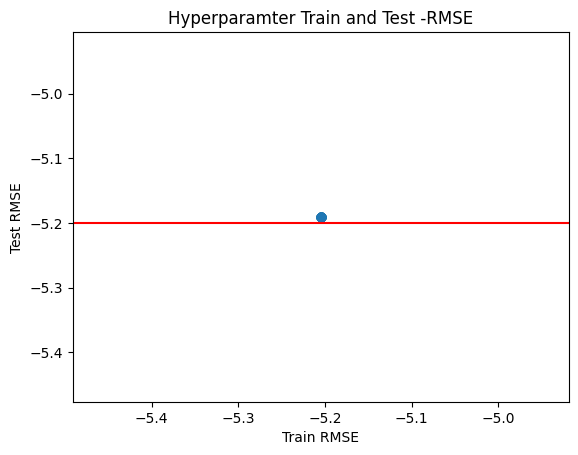

In [40]:
#Plotting the test and train gini to select best parameter
import matplotlib.pyplot as plt
plt.scatter(cv['mean_train_score'],cv['mean_test_score'] )
plt.axhline(-5.2, color='r', linestyle='-')
plt.xlabel('Train RMSE')
plt.ylabel('Test RMSE')
#for i in range(cv.shape[0]):
#    plt.text(x=cv['mean_train_score'][i],y=cv['mean_test_score'][i]+0.3,s=cv['rank_test_score'][i],fontdict=dict(size=5))
plt.title('Hyperparamter Train and Test -RMSE')
plt.show()

In [13]:
cv

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample_for_bin,param_subsample,param_num_leaves,param_n_estimators,param_min_child_weight,param_min_child_samples,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,3.910951,2.512647,0.003537,0.002922,10000,0.3,15,1600,16,20,...,-5.661272,-5.300943,-5.190662,0.436298,1,-5.484068,-4.967394,-5.162364,-5.204608,0.213036
1,3.630382,2.377919,0.001623,0.000094,10000,0.4,30,1800,16,20,...,-5.661272,-5.300943,-5.190662,0.436298,1,-5.484068,-4.967394,-5.162364,-5.204608,0.213036
2,3.404302,2.498283,0.023539,0.031449,20000,0.5,45,1600,12,20,...,-5.661272,-5.300943,-5.190662,0.436298,1,-5.484068,-4.967394,-5.162364,-5.204608,0.213036
3,6.798732,0.854731,0.003524,0.001513,5000,0.3,15,2000,16,15,...,-5.661272,-5.300943,-5.190662,0.436298,1,-5.484068,-4.967394,-5.162364,-5.204608,0.213036
4,5.876047,0.706089,0.003505,0.000187,20000,0.3,45,1800,14,10,...,-5.661272,-5.300943,-5.190662,0.436298,1,-5.484068,-4.967394,-5.162364,-5.204608,0.213036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,5.730319,1.161824,0.001732,0.000044,10000,0.5,30,1800,12,10,...,-5.661272,-5.300943,-5.190662,0.436298,1,-5.484068,-4.967394,-5.162364,-5.204608,0.213036
66,5.127544,0.714442,0.001629,0.000079,20000,0.6,45,1600,12,15,...,-5.661272,-5.300943,-5.190662,0.436298,1,-5.484068,-4.967394,-5.162364,-5.204608,0.213036
67,5.665556,0.450098,0.001744,0.000205,5000,0.6,45,2000,14,10,...,-5.661272,-5.300943,-5.190662,0.436298,1,-5.484068,-4.967394,-5.162364,-5.204608,0.213036
68,3.066554,2.102028,0.001651,0.000160,5000,0.6,15,1600,16,20,...,-5.661272,-5.300943,-5.190662,0.436298,1,-5.484068,-4.967394,-5.162364,-5.204608,0.213036


## Evaluation

In [18]:
import sklearn

### Train 

In [19]:
predictions = clf.predict(x_train)

In [20]:
mse = sklearn.metrics.mean_squared_error(y_train,predictions)
mae = sklearn.metrics.mean_absolute_error(y_train,predictions)
r2 = sklearn.metrics.r2_score(y_train,predictions)
rmse = np.sqrt(mse)

In [21]:
train_output = pd.DataFrame({'Actual':y_train,'Prediction':predictions})
train_output['Team'] = train['TEAM_NAME']
train_output['Season'] = train['SEASON']
train_output.sort_values(['Season','Prediction'],inplace=True)
metrics_list = ['MSE','MAE','R2','RMSE']
values = [mse,mae,r2,rmse]
train_results = pd.DataFrame({'METRIC':metrics_list,'VALUE':values})
train_results = train_results.transpose().reset_index(drop=True)
train_results.columns = train_results.iloc[0,:]
train_results = train_results.tail(1)

In [22]:
train_output.head()

,Actual,Prediction,Team,Season
0,0.0,0.0,Hawks,2019
5,10.0,0.0,Celtics,2019
10,0.0,0.0,Cavaliers,2019
15,0.0,0.0,Pelicans,2019
20,0.0,0.0,Bulls,2019


In [23]:
train_results

,MSE,MAE,R2,RMSE
1,27.133333,2.8,-0.406358,5.208967


### Test 

In [24]:
predictions = clf.predict(x_test)

In [25]:
mse = sklearn.metrics.mean_squared_error(y_test,predictions)
mae = sklearn.metrics.mean_absolute_error(y_test,predictions)
r2 = sklearn.metrics.r2_score(y_test,predictions)
rmse = np.sqrt(mse)

In [26]:
test_output = pd.DataFrame({'Actual':y_test,'Prediction':predictions})
test_output['Team'] = test['TEAM_NAME']
test_output['Season'] = test['SEASON']
test_output.sort_values(['Season','Prediction'],inplace=True)
metrics_list = ['MSE','MAE','R2','RMSE']
values = [mse,mae,r2,rmse]
test_results = pd.DataFrame({'METRIC':metrics_list,'VALUE':values})
test_results = test_results.transpose().reset_index(drop=True)
test_results.columns = test_results.iloc[0,:]
test_results = test_results.tail(1)

In [27]:
test_output.head()

,Actual,Prediction,Team,Season
2,1.0,0.0,Hawks,2021
7,14.0,0.0,Celtics,2021
12,0.0,0.0,Cavaliers,2021
17,2.0,0.0,Pelicans,2021
22,1.0,0.0,Bulls,2021


In [28]:
test_results

,MSE,MAE,R2,RMSE
1,27.183333,2.85,-0.426136,5.213764


### Upcoming Season 

In [32]:
x_up = upcoming[clf.best_estimator_.feature_name_]
x_up.head()

,LS_MIN,LS_EFG_PCT,LS_FTA_RATE,LS_TM_TOV_PCT,LS_OREB_PCT,LS_OPP_EFG_PCT,LS_OPP_FTA_RATE,LS_OPP_TOV_PCT,LS_OPP_OREB_PCT,HEIGHT_INCHES,WEIGHT,EXP,LS_WIN_PCT
4,17.248412,0.555474,0.240233,0.135582,0.279755,0.537575,0.270382,0.132214,0.209344,78.352941,212.705882,3.823529,0.500
9,18.700720,0.567396,0.221128,0.139701,0.204178,0.548612,0.247778,0.127512,0.215784,79.000000,224.941176,6.647059,0.695
14,16.507773,0.530249,0.235302,0.161822,0.227790,0.524138,0.278149,0.153087,0.218486,78.176471,218.588235,5.882353,0.622
19,17.913739,0.524626,0.296855,0.137225,0.239270,0.539656,0.264343,0.142655,0.217808,78.588235,214.058824,5.000000,0.512
24,19.072808,0.560886,0.257995,0.122774,0.212824,0.535775,0.251967,0.159039,0.203952,78.058824,212.000000,5.588235,0.488


In [33]:
predictions = clf.predict(x_up)
final_output = x_up.copy() 
final_output['Predicted Wins'] = predictions
final_output['Predicted Wins (Rounded)'] = [round(x) for x in predictions]
final_output['Team'] = upcoming['TEAM_NAME']
def rounds(x):
    if x < 4:
        return 'R1/Lottery'
    elif 4<=x<8:
        return 'Second Round'
    elif 8<=x<12: 
        return 'Conf. Finals'
    elif 12<=x<16:
        return 'Finals'
    elif x>=16:
        return 'Champions'
final_output['Round'] = [rounds(x) for x in final_output['Predicted Wins']]
final_output.sort_values('Predicted Wins',inplace=True)
fo = final_output[['Team','Predicted Wins','Predicted Wins (Rounded)','Round']]
fo

,Team,Predicted Wins,Predicted Wins (Rounded),Round
4,Hawks,0.0,0,R1/Lottery
139,Wizards,0.0,0,R1/Lottery
134,Grizzlies,0.0,0,R1/Lottery
129,Jazz,0.0,0,R1/Lottery
124,Raptors,0.0,0,R1/Lottery
119,Thunder,0.0,0,R1/Lottery
114,Spurs,0.0,0,R1/Lottery
109,Kings,0.0,0,R1/Lottery
104,Trail Blazers,0.0,0,R1/Lottery
99,Suns,0.0,0,R1/Lottery


In [34]:
len(list(final_output['Team']))

30

In [35]:
ec_teams = ['Hornets',
 'Wizards',
 'Hawks',
 'Pacers',
 'Magic',
 'Pistons',
 'Raptors',
 'Knicks',
 'Bulls',
 'Cavaliers',
 'Nets',
 '76ers',
 'Heat',
 'Celtics',
 'Bucks']
wc_teams = ['Thunder',
 'Rockets',
 'Spurs',
 'Trail Blazers',
 'Kings',
 'Pelicans',
 'Grizzlies',
 'Timberwolves',
 'Jazz',
 'Warriors',
 'Mavericks',
 'Lakers',
 'Clippers',
 'Suns',
 'Nuggets']

In [36]:
ec = fo[fo['Team'].isin(ec_teams)]
wc = fo[fo['Team'].isin(wc_teams)]

In [51]:
print("Bet to Win EC: ")
ecb = ec.sort_values('Predicted Wins').tail(4)
ecb

Bet to Win EC: 


,Team,Predicted Wins,Predicted Wins (Rounded),Round
14,Cavaliers,0.0,0,R1/Lottery
9,Celtics,0.0,0,R1/Lottery
144,Pistons,0.0,0,R1/Lottery
149,Hornets,0.0,0,R1/Lottery


In [52]:
print("Bet to Win WC: ")
wcb = wc.sort_values('Predicted Wins').tail(4)
wcb

Bet to Win WC: 


,Team,Predicted Wins,Predicted Wins (Rounded),Round
39,Warriors,0.0,0,R1/Lottery
34,Nuggets,0.0,0,R1/Lottery
29,Mavericks,0.0,0,R1/Lottery
19,Pelicans,0.0,0,R1/Lottery


In [53]:
print("Bet to Win NBA Finals: ")
fob = fo.sort_values('Predicted Wins').tail(4)
fob

Bet to Win NBA Finals: 


,Team,Predicted Wins,Predicted Wins (Rounded),Round
134,Grizzlies,0.0,0,R1/Lottery
139,Wizards,0.0,0,R1/Lottery
144,Pistons,0.0,0,R1/Lottery
149,Hornets,0.0,0,R1/Lottery


## Writing Info 

In [42]:
train_output['SUBSET'] = 'TRAIN'
test_output['SUBSET'] = 'TEST'
total_output = pd.concat([train_output,test_output])

,Actual,Prediction,Team,Season,SUBSET
0,0.0,0.0,Hawks,2019,TRAIN
5,10.0,0.0,Celtics,2019,TRAIN
10,0.0,0.0,Cavaliers,2019,TRAIN
15,0.0,0.0,Pelicans,2019,TRAIN
20,0.0,0.0,Bulls,2019,TRAIN
...,...,...,...,...,...
128,0.0,0.0,Jazz,2022,TEST
133,2.0,0.0,Grizzlies,2022,TEST
138,0.0,0.0,Wizards,2022,TEST
143,0.0,0.0,Pistons,2022,TEST


In [44]:
train_results['SUBSET'] = 'TRAIN'
test_results['SUBSET'] = 'TEST'
total_results = pd.concat([train_results,test_results])
total_results

,MSE,MAE,R2,RMSE,SUBSET
1,27.133333,2.8,-0.406358,5.208967,TRAIN
1,27.183333,2.85,-0.426136,5.213764,TEST


In [41]:
model_name = input()

first_lgbm_sample


In [49]:
initial_path = ''
cv_path = initial_path+model_name+'_cv_results.csv'
output_path = initial_path+model_name+'_output.csv'
results_path = initial_path+model_name+'_results.csv'
predictions_path = initial_path+model_name+'_full_predictions.csv'
ec_path = initial_path+model_name+'_ecf_predictions.csv'
wc_path = initial_path+model_name+'_wcf_predictions.csv'
f_path = initial_path+model_name+'_finals_predictions.csv'
print(cv_path)
print(output_path)
print(results_path)
print(predictions_path)
print(ec_path)
print(wc_path)
print(f_path)

first_lgbm_sample_cv_results.csv
first_lgbm_sample_output.csv
first_lgbm_sample_results.csv
first_lgbm_sample_full_predictions.csv
first_lgbm_sample_ecf_predictions.csv
first_lgbm_sample_wcf_predictions.csv
first_lgbm_sample_finals_predictions.csv


In [54]:
cv.to_csv(cv_path,index=False)
total_output.to_csv(output_path,index=False)
total_results.to_csv(results_path,index=False)
fo.to_csv(predictions_path,index=False)
ecb.to_csv(ec_path,index=False)
wcb.to_csv(wc_path,index=False)
fob.to_csv(f_path,index=False)

In [55]:
import pickle

# save the model to disk
filename = model_name+'.sav'
pickle.dump(clf, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
#loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, Y_test)
#print(result)